# Plot water stress

## 1. Settings

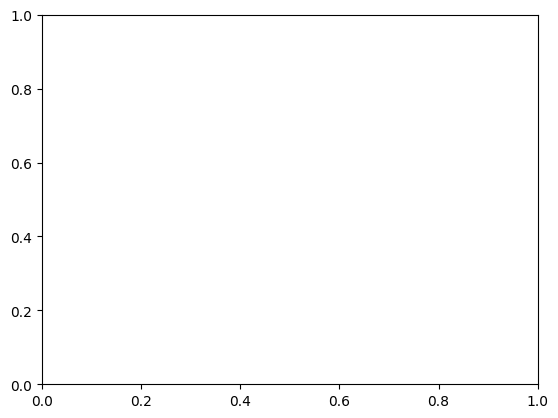

In [1]:
# laod modules 
import xarray as xr
import matplotlib.pyplot as plt
import os
import regionmask 
import pandas as pd
import matplotlib.patheffects as pe

# import own utils module
from iv_utils_daint import *
from ctsm_py.utils import * #info on ctsm utils: https://github.com/NCAR/ctsm_python_gallery 

# do plotting settings
set_plot_param()

# ignore all runtime warnings
warnings.filterwarnings('ignore')

In [2]:
# directory settings

# set directories
outdir = '/project/s1207/ivanderk/scratch/'
figdir = '/users/ivanderk/notebooks_4p1000/figures/'

# Define directory where processing is done 
procdir =  outdir + 'processing_4p1000/' 

# go to processing directory 
os.chdir(procdir)

# define scenario
scenario = '4p1000'

# case settings
case_ctl = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.CTL.spunup5'
case_scen = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.'+scenario+'.spunup5'

case   = case_ctl
block  = 'lnd' 
stream = 'h1' 

# List of variables to import from file(s) in $indir matching $pattern.
variables = ['H2OSOI',"TOTSOILLIQ","TOTSOILICE", "QINFL" , "QOVER", "QDRAI", 'EFLX_LH_TOT',  "watsat","QROOTSINK" ,"QVEGE", "QVEGT","QSOIL",
             "watfc", "EFF_POROSITY", ] #"SOILPSI", "FPSN","QHR","SMP","GSSHA","GSSUN"

# discard 2004 until 2008 as spin up years
start_year, end_year = 1995, 2014 

time_slice = slice(str(start_year)+"-01-01", str(end_year)+"-12-01")

proj =  ccrs.PlateCarree()


In [3]:
## settings for plotting
ds_ctl =  load_case_ctl(['H2OSOI'])

# get mask and region ids
exclude_ids = np.array([0,1,2,16,28,29,30,31])
mask_regions = regionmask.defined_regions.ar6.land.mask(ds_ctl['H2OSOI'])

region_ids = np.arange(0,44)
region_ids = np.delete(region_ids, exclude_ids)
region_ids_sel = [3,19,23]

regions_sand_clay = [6, 7, 10, 11, 12, 14, 19, 21, 22, 23, 24, 26, 37, 38, 39, 41]

plotting_depth = 1 # m 8
figsize = (17,38)

labels = ['a.','b.','c.','d.','e.','f.','g.','h.','i.','j.']

# get pfts modelled - bare soil, grassland and crop pfts
pft_list_crops = [15,16]
pft_list_grassland = [0,12,13,14]

pft_int = 15

### Load auxiliary data (soil levels, input dataset, wilting point etc) 

In [4]:
# info on soil levels
# manually get soil level info from CLM
levsoi_thickness, levsoi_depth, levgrnd_thickness , levgrnd_depth = get_soildepths()

# get info on soil levels
levsoi = ds_ctl['levsoi'].values
levgrnd = ds_ctl['levgrnd'].values # all soil layers (deepest 5 layers are for thermodynamical calculations)

# input data
# define variables to load from input dataset
input_variables = ['ORGANIC','PFTDATA_MASK','PCT_SAND','PCT_CLAY', 'PCT_CFT']

# load inputdata
ds_input, ds_input_scen, landmask = load_inputdata(scenario, input_variables, case_ctl)

da_irrigated_mask = ds_input['PCT_CFT'].sel(cft=16)>0


## Plot cumulative water stress

In [8]:
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

xr.open_dataset('/project/s1207/ivanderk/scratch/processing_4p1000/postprocessing/pft_gridding/H2OSOI_15.IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.CTL.spunup5.nc', engine="h5netcdf")

OSError: [Errno 524] Unable to synchronously open file (unable to lock file, errno = 524, error message = 'Unknown error 524')

In [6]:
scenario = 'high'

case_ctl = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.CTL.spunup5'
case_scen = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.'+scenario+'.spunup5'

variable = "H2OSOI" 

da_ctl = load_da_gridded_pft(variable, pft_int, case_ctl).rename(variable).isel(levsoi=range(0,10))
da_scen = load_da_gridded_pft(variable, pft_int, case_scen).rename(variable).isel(levsoi=range(0,10))

da_wilting_h2osoi, da_wilting_h2osoi_scen = load_wilting_h2osoi(scenario)

da_wilting_h2osoi['levsoi'] = da_pft_ctl.levsoi.isel(levsoi=range(0,10))
da_wilting_h2osoi_scen['levsoi'] = da_pft_scen.levsoi.isel(levsoi=range(0,10))

da_stress_cumulative_ctl  = calc_annual_cumulative_stress(da_ctl,  da_wilting_h2osoi) 
da_stress_cumulative_scen = calc_annual_cumulative_stress(da_scen, da_wilting_h2osoi_scen) 

da_delta_stress = (da_stress_cumulative_scen - da_stress_cumulative_ctl).mean('year').squeeze().compute()

da_delta_stress_mm = (da_delta_stress*np.expand_dims(np.expand_dims(levsoi_thickness[0:10], axis=1), axis=2)*1000).sum('levsoi')

fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111, projection=proj)

levels = np.arange(-0.5,0.55,0.05)
(da_delta_stress_mm*10e-3).where(landmask).plot(ax=ax, cmap='PuOr_r', cbar_kwargs={'label': 'meters', 'fraction': 0.02, 'pad': 0.04}) #, levels=levels)
ax.set_title(' ', loc='center')
ax.set_title('Mean annual soil column $\Delta$ cumulative water stress (m)', loc='right')
ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_extent((-180,180,-63,90), crs=proj);
ax.axis('off');



OSError: [Errno -101] NetCDF: HDF error: '/project/s1207/ivanderk/scratch/processing_4p1000/postprocessing/pft_gridding/H2OSOI_15.IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.CTL.spunup5.nc'

In [ ]:
da_delta_stress_mm_upper60cm = (da_delta_stress[0:7,:,:]*np.expand_dims(np.expand_dims(levsoi_thickness[0:7], axis=1), axis=2)*1000).sum('levsoi')

fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111, projection=proj)

levels = np.arange(-0.5,0.55,0.05)
(da_delta_stress_mm_upper60cm*10e-3).where(landmask).where(da_clay_mask).plot(ax=ax, cmap='PuOr_r', cbar_kwargs={'label': 'meters', 'fraction': 0.02, 'pad': 0.04})#, levels=levels)
ax.set_title(' ', loc='center')
ax.set_title('Mean annual soil column upper 60 cm $\Delta$ cumulative water stress (m)', loc='right')
ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_extent((-180,180,-63,90), crs=proj);
ax.axis('off');



In [5]:
scenario = '4p1000'

case_ctl = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.CTL.spunup5'
case_scen = 'IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.'+scenario+'.spunup5'

variable = "H2OSOI" 

da_ctl = load_da_gridded_pft(variable, pft_int, case_ctl).rename(variable).isel(levsoi=range(0,10))
da_scen = load_da_gridded_pft(variable, pft_int, case_scen).rename(variable).isel(levsoi=range(0,10))

da_wilting_h2osoi, da_wilting_h2osoi_scen = load_wilting_h2osoi(scenario) 

da_wilting_h2osoi['levsoi'] = da_pft_ctl.levsoi.isel(levsoi=range(0,10))
da_wilting_h2osoi_scen['levsoi'] = da_pft_scen.levsoi.isel(levsoi=range(0,10))

da_stress_cumulative_ctl  = calc_annual_cumulative_stress(da_ctl,  da_wilting_h2osoi) 
da_stress_cumulative_scen = calc_annual_cumulative_stress(da_scen, da_wilting_h2osoi_scen) 

da_delta_stress = (da_stress_cumulative_scen - da_stress_cumulative_ctl).mean('year').squeeze().compute()

da_delta_stress_mm = (da_delta_stress*np.expand_dims(np.expand_dims(levsoi_thickness[0:10], axis=1), axis=2)*1000).sum('levsoi')

fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111, projection=proj)

levels = np.arange(-0.5,0.55,0.05)
(da_delta_stress_mm*10e-3).where(landmask).plot(ax=ax, cmap='PuOr_r', cbar_kwargs={'label': 'meters', 'fraction': 0.02, 'pad': 0.04}) #, levels=levels)
ax.set_title(' ', loc='center')
ax.set_title('Mean annual soil column $\Delta$ cumulative water stress (m)', loc='right')
ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_extent((-180,180,-63,90), crs=proj);
ax.axis('off');



OSError: [Errno -101] NetCDF: HDF error: '/project/s1207/ivanderk/scratch/processing_4p1000/postprocessing/pft_gridding/H2OSOI_15.IHistClm51Sp.hcru_hcru_mt13.pftsoilcol.CTL.spunup5.nc'

In [ ]:
da_delta_stress_mm_upper60cm = (da_delta_stress[0:7,:,:]*np.expand_dims(np.expand_dims(levsoi_thickness[0:7], axis=1), axis=2)*1000).sum('levsoi')

fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111, projection=proj)

levels = np.arange(-0.5,0.55,0.05)
(da_delta_stress_mm_upper60cm*10e-3).where(landmask).plot(ax=ax, cmap='PuOr_r', cbar_kwargs={'label': 'meters', 'fraction': 0.02, 'pad': 0.04})#, levels=levels)
ax.set_title(' ', loc='center')
ax.set_title('Mean annual soil column upper 60 cm $\Delta$ cumulative water stress (m)', loc='right')
ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_extent((-180,180,-63,90), crs=proj);
ax.axis('off');


da_delta_stress_mm_upper30cm = (da_delta_stress[0:4,:,:]*np.expand_dims(np.expand_dims(levsoi_thickness[0:4], axis=1), axis=2)*1000).sum('levsoi')

fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111, projection=proj)

levels = np.arange(-0.5,0.55,0.05)
(da_delta_stress_mm_upper60cm*10e-3).where(landmask).plot(ax=ax, cmap='PuOr_r', cbar_kwargs={'label': 'meters', 'fraction': 0.02, 'pad': 0.04})#, levels=levels)
ax.set_title(' ', loc='center')
ax.set_title('Mean annual soil column upper 60 cm $\Delta$ cumulative water stress (m)', loc='right')
ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_extent((-180,180,-63,90), crs=proj);
ax.axis('off');

In [ ]:
da_delta_stress_mm_upper60cm = (da_delta_stress[0:7,:,:]*np.expand_dims(np.expand_dims(levsoi_thickness[0:7], axis=1), axis=2)*1000).sum('levsoi')

fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111, projection=proj)

levels = np.arange(-0.5,0.55,0.05)
(da_delta_stress_mm_upper60cm*10e-3).where(landmask).where(da_sand_mask).plot(ax=ax, cmap='PuOr_r', cbar_kwargs={'label': 'meters', 'fraction': 0.02, 'pad': 0.04})#, levels=levels)
ax.set_title(' ', loc='center')
ax.set_title('Mean annual soil column upper 60 cm $\Delta$ cumulative water stress (m)', loc='right')
ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_extent((-180,180,-63,90), crs=proj);
ax.axis('off');




In [ ]:
da_delta_stress_mm_upper60cm = (da_delta_stress[0:7,:,:]*np.expand_dims(np.expand_dims(levsoi_thickness[0:7], axis=1), axis=2)*1000).sum('levsoi')

fig = plt.figure(figsize=(12,5))
ax = plt.subplot(111, projection=proj)

levels = np.arange(-0.5,0.55,0.05)
(da_delta_stress_mm_upper60cm*10e-3).where(landmask).where(da_irrigated_mask).plot(ax=ax, cmap='PuOr_r', cbar_kwargs={'label': 'meters', 'fraction': 0.02, 'pad': 0.04})#, levels=levels)
ax.set_title(' ', loc='center')
ax.set_title('Mean annual soil column upper 60 cm $\Delta$ cumulative water stress (m)', loc='right')
ax.coastlines(color='dimgray', linewidth=0.5)
ax.set_extent((-180,180,-63,90), crs=proj);
ax.axis('off');

